# Flare Isolation
The goal of this notebook is to isolate the flares from stars' background behavior for anaylsis (energy, shape without other contributions)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy import constants as const

from scipy.linalg import lstsq
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.integrate import simps

import lightkurve as lk

import altaipony as ap
from altaipony.flarelc import FlareLightCurve

%matplotlib inline

import pickle

c:\Users\vishn\miniconda3\envs\SPT_Flares\lib\site-packages\lightkurve\config\__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to C:\Users\vishn\.lightkurve\cache. Please move all the files in the legacy directory C:\Users\vishn\.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


Grab identifying data of coinciding flares from `..\data\spt_tess_candidates_tandoi24.pkl`.

In [2]:
coinciding_flares_df = pd.read_pickle('..\..\data\spt_tess_candidates_tandoi24.pkl')
print(coinciding_flares_df.columns)
coinciding_flares_df

Index(['index', 'spt_id', 'mjd', 'ts', 'ra', 'dec', '95_flux', '95_flux_err',
       '150_flux', '150_flux_err', '220_flux', '220_flux_err',
       'spectral_index_95_150', 'spectral_index_95_150_err',
       'spectral_index_150_220', 'spectral_index_150_220_err', 'dr3_source_id',
       'p-value', 'source_ra', 'source_dec', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'parallax_err',
       'binary', '2rxs_id', '2rxs_ref', '2rxs_flux', 'sectors', 'TIC'],
      dtype='object')


<>:1: DeprecationWarning: invalid escape sequence \.
<>:1: DeprecationWarning: invalid escape sequence \.
C:\Users\vishn\AppData\Local\Temp\ipykernel_11028\3896666550.py:1: DeprecationWarning: invalid escape sequence \.
  coinciding_flares_df = pd.read_pickle('..\..\data\spt_tess_candidates_tandoi24.pkl')


,index,spt_id,mjd,ts,ra,dec,95_flux,95_flux_err,150_flux,150_flux_err,...,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_err,binary,2rxs_id,2rxs_ref,2rxs_flux,sectors,TIC
0,42,SPT-SV J232857.8-680230,59067.63,69.829680,352.241137,-68.041907,33.132387,6.050987,44.396645,6.479653,...,13.298294,10.835975,21.814973,0.016096,True,2RXS J232857.7-680225,Freund,0.0,[28],TIC229807000
1,43,SPT-SV J220610.2-460354,59068.28,65.720511,331.542835,-46.065046,47.818806,8.045753,50.842904,8.377214,...,11.394999,10.820612,2.686802,0.032307,False,NaN,NaN,NaN,[28],TIC279255411
2,46,SPT-SV J025532.4-570257,59110.27,1233.665708,43.885140,-57.049441,162.083004,7.148120,206.963060,7.665012,...,16.325182,13.060138,21.889704,0.021013,False,NaN,NaN,NaN,[29],TIC207138379
3,49,SPT-SV J014432.2-460435,59131.78,48.975169,26.134435,-46.076393,45.598152,8.294850,36.632626,8.695313,...,18.198709,14.208293,25.949235,0.045132,False,NaN,NaN,NaN,[30],TIC401838575


Pull highest cadence TESS lightcurve with lightkurve

In [3]:
flare_star = coinciding_flares_df.iloc[3]
obj = lk.search_lightcurve(flare_star['TIC'], mission= 'TESS', sector= flare_star["sectors"][0], exptime= 'fast')
if len(obj) == 0: obj = lk.search_lightcurve(flare_star['TIC'], mission= 'TESS', sector= flare_star["sectors"][0], exptime= 'short')
if len(obj) == 0: obj = lk.search_lightcurve(flare_star['TIC'], mission= 'TESS', sector= flare_star["sectors"][0])
flare_lc = obj[0].download()

3% (102/3783) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
3% (102/3783) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


In [4]:
# print(type(flare_lc), type(flare_lc.flux), type(flare_lc.sap_flux), type(flare_lc.pdcsap_flux))
# print(flare_lc.flux.shape, flare_lc.flux.unit, flare_lc.sap_flux.unit, flare_lc.pdcsap_flux.unit)

`lightkurve.lightcurve` objects store flux/sap_flux/pdcsap_flux as `<class 'astropy.utils.masked.core.MaskedQuantity'>`, which breaks as lightkurves own implementation of `lightcurve.normalize()` & `lightcurve.flatten()`. We will get around this by re-assigning with the unmasked values (which should be standard `numpy.ndarray`).

In [5]:
flare_lc.flux = flare_lc.flux.unmasked
flare_lc.flux_err = flare_lc.flux_err.unmasked
flare_lc.sap_flux = flare_lc.sap_flux.unmasked
flare_lc.sap_flux_err = flare_lc.sap_flux_err.unmasked
flare_lc.pdcsap_flux = flare_lc.pdcsap_flux.unmasked
flare_lc.pdcsap_flux_err = flare_lc.pdcsap_flux_err.unmasked
flare_lc = flare_lc.remove_nans()

1943 59131.77717121067 2132.277971931897
Dominant Frequency: 3.17346 1 / d <-> Dominant Period: 0.31511 d -> Max Power: 1.74236 electron / s


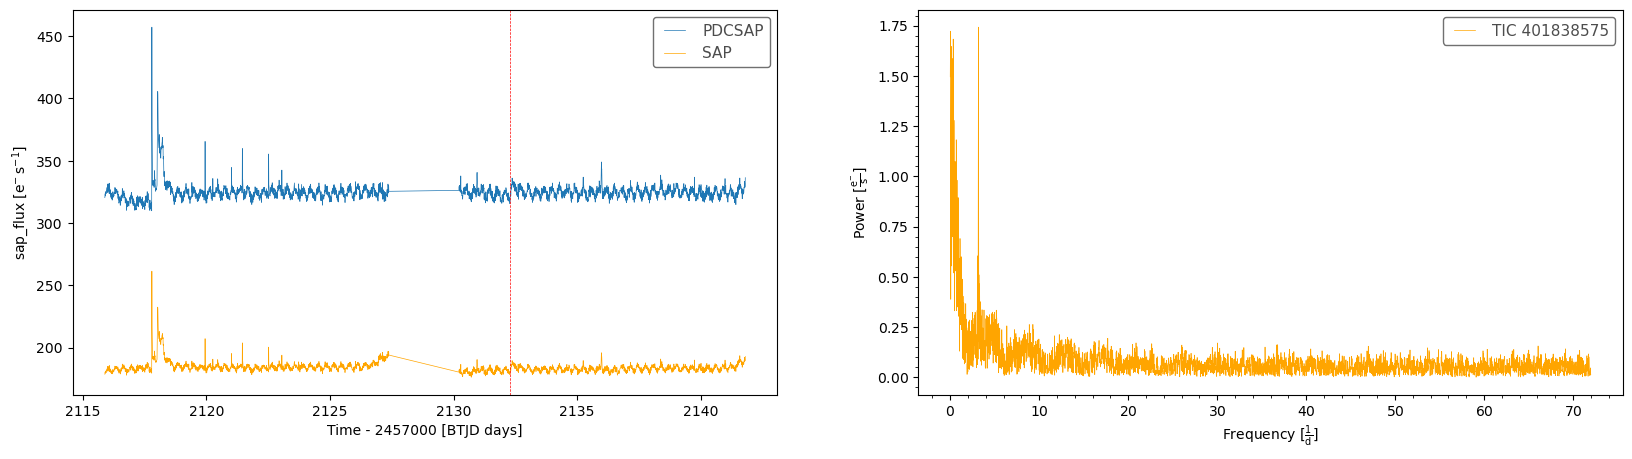

In [6]:
flare_lc = flare_lc.remove_nans()

# time_tdb = Time(flare_lc.time.value, format= 'mjd', scale= 'tdb')
# time_utc = time_tdb.utc.mjd
# flare_lc.time = time_utc
# print(time_tdb[0])
# print(time_utc[0])
# print(flare_lc.time.value[0])

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))
flare_lc.plot(ax= ax1, column= 'pdcsap_flux', label="PDCSAP")
flare_lc.plot(ax= ax1, column= 'sap_flux', label="SAP", color= 'orange')

time_tdb = Time(flare_lc.time.value, format= flare_lc.time.format, scale= flare_lc.time.scale)
time_utc = time_tdb.utc.mjd
flare_start_idx = np.abs(time_utc-flare_star['mjd']).argmin()
print(flare_start_idx, time_utc[flare_start_idx], flare_lc.time.value[flare_start_idx])
ax1.axvline(flare_lc.time.value[flare_start_idx], ls= '--', lw= 0.5, c= 'r')

flare_lc = flare_lc.select_flux('sap_flux')
p = flare_lc.to_periodogram('ls')
p.plot(ax = ax2, color= 'orange')
# ax2.set_xlim(-2,100)
print(f'Dominant Frequency: {p.frequency_at_max_power:.5f} <-> Dominant Period: {p.period_at_max_power:.5f} -> Max Power: {p.max_power:.5f}')


## Removing Quiescent Behaviors

Dominant Frequency: 3.17346 1 / d <-> Dominant Period: 0.31511 d -> Max Power: 1.74236 electron / s


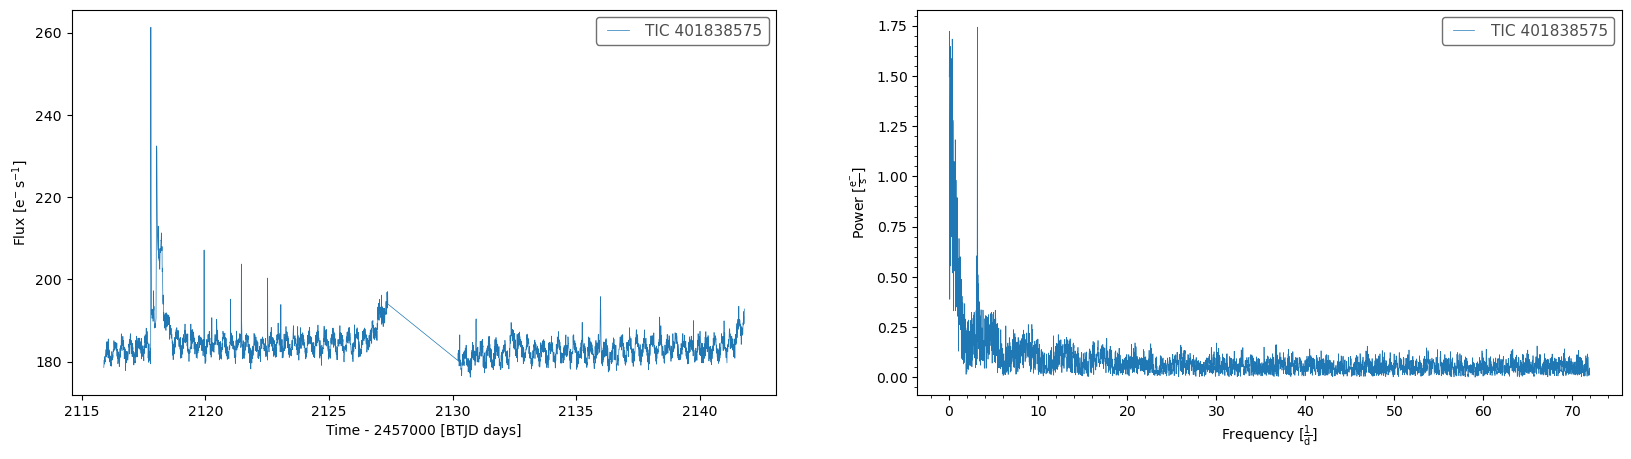

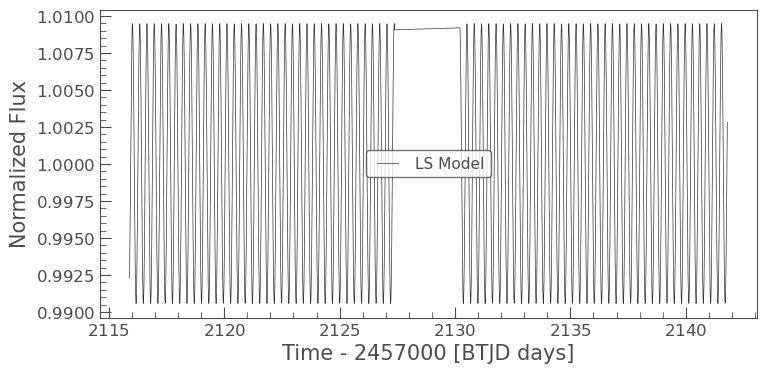

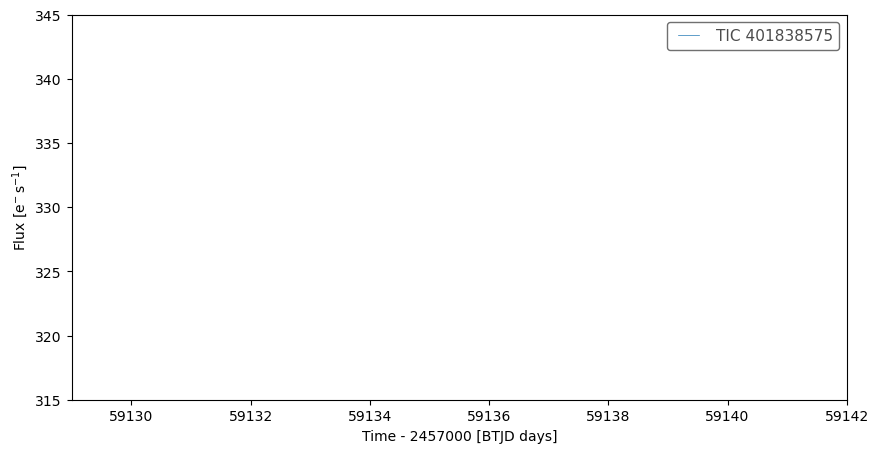

In [7]:
lc = flare_lc.copy()
lc = lc.remove_nans()
iterations = 1
for i in range(iterations):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))
    lc.plot(ax=ax1)

    p = lc.to_periodogram('ls')
    p.plot(ax = ax2)
    # ax2.set_xlim(0,3)
    print(f'Dominant Frequency: {p.frequency_at_max_power:.5f} <-> Dominant Period: {p.period_at_max_power:.5f} -> Max Power: {p.max_power:.5f}')

    model = p.model(lc.time, p.frequency_at_max_power)
    model.plot()

    lc.flux = lc.flux / model['flux']

f, ax = plt.subplots(figsize=(10, 5))
lc.plot(ax= ax)
ax.set_xlim(59129, 59142)
ax.set_ylim(315, 345)
# ax.set_ylim(175, 195)
ax.axvline(flare_lc.time.value[flare_start_idx], ls= '--', lw= 0.5, c= 'r')

### AltaiPony

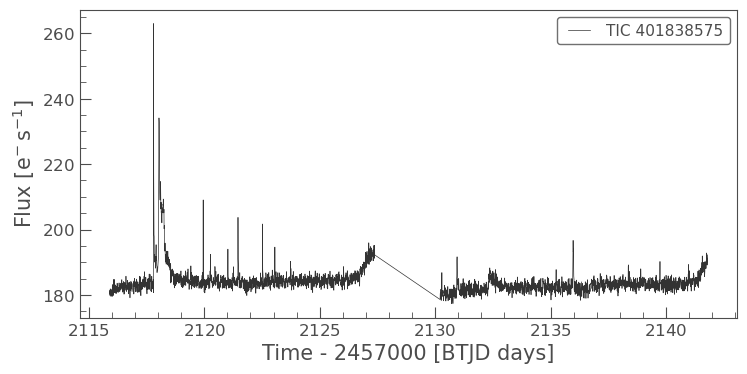

In [8]:
flc = FlareLightCurve(lc)
ax = flc.plot()

window length: 201
window length: 201


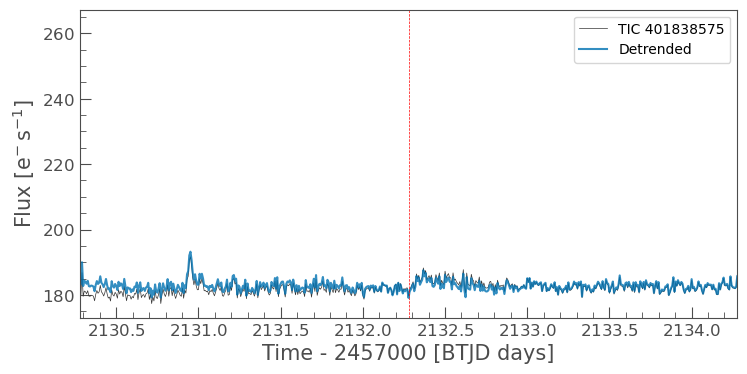

In [9]:
flc = flc.detrend(mode= 'savgol', printwl= True, window_length= 201)
ax = flc.plot()
ax.plot(flc.time.value, flc.detrended_flux.value, label='Detrended', alpha= 0.8)
ax.legend()
ax.axvline(flare_lc.time.value[flare_start_idx], ls= '--', lw= 0.5, c= 'r')
ax.set_xlim(flare_lc.time.value[flare_start_idx] - 2, flare_lc.time.value[flare_start_idx] + 2)
# ax.set_ylim(315, 345)
plt.show()

In [10]:
flc = flc.find_flares(N1= 1, N2= 1)
flc.flares

Found 5 candidate(s) in the (0,1647) gap.
Found 9 candidate(s) in the (1647,3308) gap.
c:\Users\vishn\miniconda3\envs\SPT_Flares\lib\site-packages\altaipony\altai.py:210: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lc.flares = pd.concat([lc.flares, new], ignore_index=True)


,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points
0,270,378,128208,128316,2117.798983,2118.548979,4845.741755,33.134988,0.425263,0.749996,3308.0
1,797,801,128735,128739,2121.458678,2121.486456,118.673089,6.839687,0.108506,0.027778,3308.0
2,1592,1601,129534,129543,2127.007218,2127.069717,113.735262,13.453019,0.033733,0.062499,3308.0
3,1605,1608,129547,129550,2127.097494,2127.118327,41.083254,8.280014,0.027229,0.020833,3308.0
4,1612,1646,129554,129588,2127.146104,2127.382212,584.390802,27.835651,0.043837,0.236107,3308.0
5,1749,1755,130099,130105,2130.930774,2130.972440,131.980834,9.524285,0.057707,0.041666,3308.0
6,1956,1959,130306,130309,2132.368248,2132.389081,39.115040,7.131849,0.026550,0.020833,3308.0
7,2473,2481,130824,130832,2135.965390,2136.020944,208.083833,10.647208,0.078747,0.055554,3308.0
8,2679,2682,131035,131038,2137.430630,2137.451463,28.177664,7.229595,0.016736,0.020833,3308.0
9,2814,2817,131170,131173,2138.368104,2138.388937,45.403487,7.011239,0.031300,0.020833,3308.0


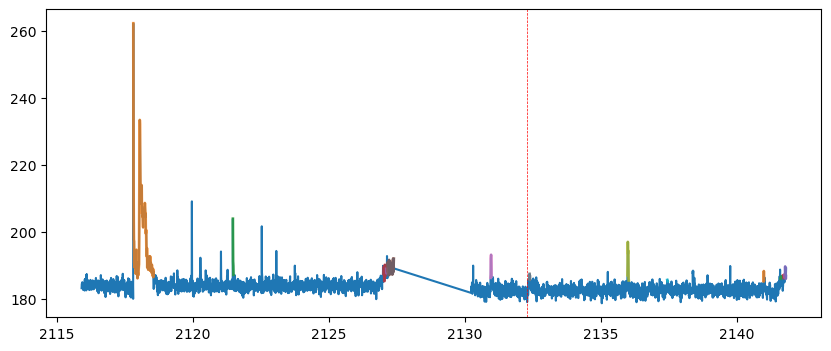

In [11]:
f, ax = plt.subplots(1,1, figsize= (10,4))
ax.plot(flc.time.value, flc.detrended_flux.value)
for flare in flc.flares.iterrows():
    flare = flare[1]
    istart = flare['istart']
    istop = flare['istop']
    ax.plot(flc.time.value[istart:istop], flc.detrended_flux.value[istart:istop], alpha= 0.75, linewidth= 2)
ax.axvline(flare_lc.time.value[flare_start_idx], ls= '--', lw= 0.5, c= 'r')

Isolate Gap 2 as baseline may change and calculate quiscent by masking out flares

<span style="color:red; font-weight:bold;"> It feels like theres still a lot of systematics burried in the smaller timescales that are not removed by detrending, so try to address that here by cutting shorter time window for calculating relative flux.</span> 


Quiescent Flux: 182.247 electron / s +/- 1.324 electron / s


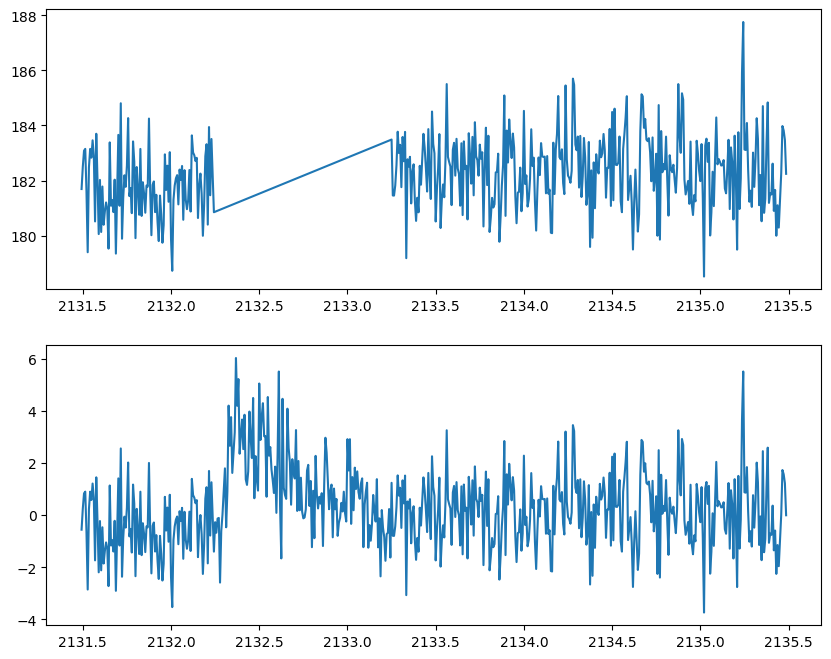

In [12]:
large_flare_start = np.where(flc.time.value < 2131.5)[0][-1]
large_flare_end = np.where(flc.time.value < 2135.5)[0][-1]

flare_sig = {
    "time": flc.time[large_flare_start:large_flare_end].copy(),
    "flux": flc.flux[large_flare_start:large_flare_end].copy(),
    "flux_err": flc.flux_err[large_flare_start:large_flare_end].copy(),
    "quies_subtr": flc.flux[large_flare_start:large_flare_end].copy(),
    "quies_subtr_err": flc.flux[large_flare_start:large_flare_end].copy(),
}

flare_mask = np.zeros_like(flare_sig['time'], dtype=bool)
for _, flare_row in flc.flares.iterrows():
    tstart = flare_row['tstart']
    tstop = flare_row['tstop']
    istart = np.where(flare_sig['time'].value == tstart)[0] - 6 # 12 min extension
    istop = np.where(flare_sig['time'].value == tstop)[0] + 6 # 12 min extension
    # print(istart, istop, tstart, tstop)
    if istart.size != 0 and istop.size != 0: flare_mask[istart[0]:istop[0]] = True

flare_mask[(flare_sig['time'].value > 2132.25) & (flare_sig['time'].value < 2133.25)] = True
flare_mask[(flare_sig['time'].value < 2130.5)] = True

f, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8))
ax1.plot(flare_sig['time'][~flare_mask].value, flare_sig['flux'][~flare_mask].value)

quies = np.mean(flare_sig['flux'][~flare_mask])
quies_err = np.std(flare_sig['flux'][~flare_mask])
print(f'Quiescent Flux: {quies:.3f} +/- {quies_err:.3f}')
flare_sig['quies_subtr'] -= quies
flare_sig['quies_subtr_err'] += quies_err #? Is this proper error propagation?
ax2.plot(flare_sig['time'].value, flare_sig['quies_subtr'].value)

# Fit Flare Shape

Rough clip to SPT flare region

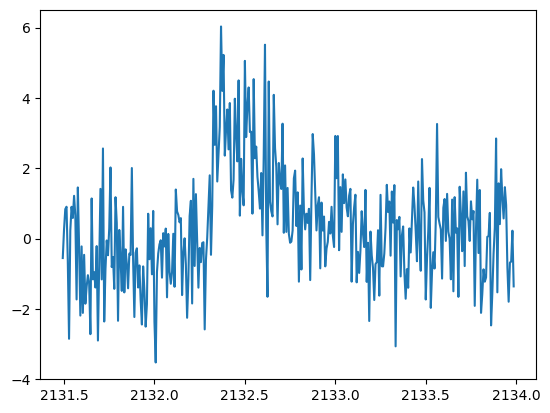

In [13]:
large_flare_start = np.where(flare_sig['time'].value < 2131.5)[0][-1]
large_flare_end = np.where(flare_sig['time'].value < 2134)[0][-1]
SPT_flare = flare_sig.copy()
SPT_flare['time'] = SPT_flare['time'][large_flare_start:large_flare_end]
SPT_flare['flux'] = SPT_flare['flux'][large_flare_start:large_flare_end]
SPT_flare['flux_err'] = SPT_flare['flux_err'][large_flare_start:large_flare_end]
SPT_flare['quies_subtr'] = SPT_flare['quies_subtr'][large_flare_start:large_flare_end]
SPT_flare['quies_subtr_err'] = SPT_flare['quies_subtr_err'][large_flare_start:large_flare_end]

plt.plot(SPT_flare['time'].value, SPT_flare['quies_subtr'].value, label='Quiescent Subtracted')

Identify integration bounds by when moving average approaches quiescent mean

Flare region: start at time 2132.326582099552, end at time 2133.2223972732813


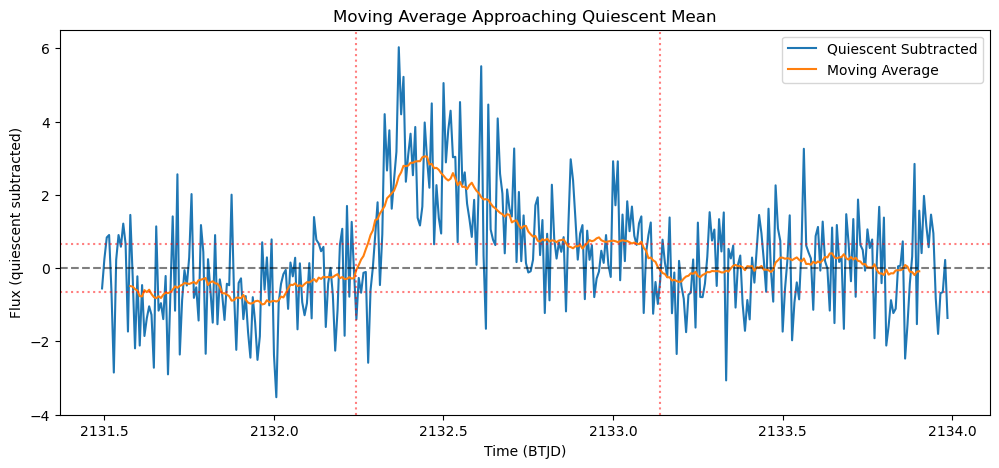

In [14]:
window_size = 25  # Adjust window size as needed
moving_avg = np.convolve(SPT_flare['quies_subtr'], np.ones(window_size)/window_size, mode='valid')

# Find the flare peak index (maximum absolute deviation from quiescent)
peak_idx = np.argmax(np.abs(SPT_flare['quies_subtr'].value))
# Search for threshold crossings starting from the peak
search_indices = np.arange(peak_idx, len(moving_avg))

# Find where moving average drops below threshold after the peak (end of flare)
end_candidates = search_indices[np.where(moving_avg[search_indices] < 0)[0]]
if len(end_candidates) > 0:
    last_idx = end_candidates[0] + window_size//2  # Adjust for moving average window
else:
    last_idx = len(moving_avg) - 1

# Find where moving average rises above threshold before the peak (start of flare)
search_indices_rev = np.arange(peak_idx, -1, -1)
start_candidates = search_indices_rev[np.where(moving_avg[search_indices_rev] < 0)[0]]
if len(start_candidates) > 0:
    first_idx = start_candidates[0] + window_size//2  # Adjust for moving average window
else:
    first_idx = 0

print(f"Flare region: start at time {SPT_flare['time'][first_idx + window_size//2]}, end at time {SPT_flare['time'][last_idx + window_size//2]}")

plt.figure(figsize=(12,5))
plt.plot(SPT_flare['time'].value, SPT_flare['quies_subtr'].value, label='Quiescent Subtracted')
plt.plot(SPT_flare['time'].value[window_size//2:-(window_size//2)], moving_avg, label='Moving Average')
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(0.5 * quies_err.value, color='r', linestyle=':', alpha=0.5)
plt.axhline(-0.5 * quies_err.value, color='r', linestyle=':', alpha=0.5)
plt.axvline(SPT_flare['time'][first_idx].value, color='r', linestyle=':', alpha=0.5)
plt.axvline(SPT_flare['time'][last_idx].value, color='r', linestyle=':', alpha=0.5)
plt.legend()
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux (quiescent subtracted)')
plt.title('Moving Average Approaching Quiescent Mean')
plt.show()

Find fwhm to rescale time axis if needed

In [15]:
t = SPT_flare['time'].value[window_size//2:-(window_size//2)]
y = moving_avg.value

# t = SPT_flare['time'].value
# y = SPT_flare['quies_subtr'].value

# Assume t and y are arrays for time and normalized flux
half_max = 0.5 * np.max(y)

# Build interpolation function over time
interp_func = interp1d(t, y, kind='cubic', bounds_error=False)

# Create high-res time grid
t_fine = np.linspace(t[0], t[-1], 10000)
y_fine = interp_func(t_fine)

# Detect crossings on interpolated curve
above_half = y_fine >= half_max
rising_edges = np.where(np.diff(above_half.astype(int)) == 1)[0]
falling_edges = np.where(np.diff(above_half.astype(int)) == -1)[0]

if len(rising_edges) > 0 and len(falling_edges) > 0:
    t_rise = t_fine[rising_edges[0]]
    t_fall = t_fine[falling_edges[0]]
    fwhm = t_fall - t_rise

    print(f"Rise: {t_rise:.5f} d ({t_rise*24*60:.2f} min), "
          f"Fall: {t_fall:.5f} d ({t_fall*24*60:.2f} min), "
          f"FWHM: {fwhm:.5f} d ({fwhm*24*60:.2f} min)")
else:
    print("Could not determine FWHM on interpolated data.")

Rise: 2132.31412 d (3070532.33 min), Fall: 2132.66450 d (3071036.88 min), FWHM: 0.35038 d (504.55 min)


<span style="color:red; font-weight:bold;"> This might be cheating</span> 


In [16]:
fwhm/=4

In [17]:
# Prepare data for fitting
t = SPT_flare['time'].value
y = SPT_flare['quies_subtr'].value

t_peak = t[np.argmax(y)]
t_fwhm = (t - t_peak) / fwhm

scaling = np.max(SPT_flare['quies_subtr'].value)  # Scale factor for normalization
y_rel = SPT_flare['quies_subtr'].value / scaling  # Normalize the flux for fitting

Text(0.5, 1.0, 'Normalized & FWHM Scaled Flux')

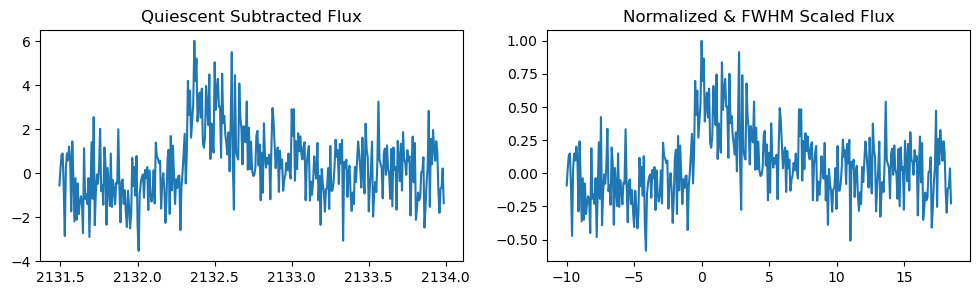

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(t, y)
ax1.set_title('Quiescent Subtracted Flux')
ax2.plot(t_fwhm, y_rel)
ax2.set_title('Normalized & FWHM Scaled Flux')

In [19]:
# Define flare template functions
def gauss(t, t_peak, amp, sigma, offset):
    """Simple Gaussian function for flare fitting.
        Suggested by Howard and MacGregor (2023) for non_optical flares.
    """
    result = np.zeros_like(t)
    result = amp * np.exp(-0.5 * ((t - t_peak) / sigma) ** 2)
    return result + offset

def gauss_exp_decay(t, t_peak, amp, sigma, tau, offset):
    """No idea where I got this from :'|"""
    result = np.zeros_like(t)
    # Gaussian part for t <= t_peak
    mask_rise = t <= t_peak
    result[mask_rise] = amp * np.exp(-0.5 * ((t[mask_rise] - t_peak) / sigma) ** 2)
    # Exponential decay for t > t_peak
    mask_decay = t > t_peak
    result[mask_decay] = amp * np.exp(-0.5) * np.exp(-(t[mask_decay] - t_peak) / tau)
    return result + offset

def two_component_gaussian(t, t_peak, amp, sigma_rise, sigma_decay, offset):
    """Asymmetric Gaussian: different sigma for rise and decay.
        Used in Howard and MacGregor (2023) for flares with QPP substructure.
    """
    sigma = np.where(t < t_peak, sigma_rise, sigma_decay)
    return amp * np.exp(-0.5 * ((t - t_peak) / sigma) ** 2) + offset

def Davenport14_flare_template(t_fwhm, a, b, c, d, e, ea, f, fa):
    """Davenport et al. (2014) flare template function: 4th order polynomial rise with double exponential decay.
        Works for t_fwhm in days, normalized to FWHM and relative flux.
        The do have another possible parameterization of the decay, with the two decay terms "on" for distict regions of time,
        but this form seems better equipped for a variety of flares.
    """
    result = np.zeros_like(t_fwhm)
    mask_baseline = (t_fwhm < -1)
    result[mask_baseline] = 0
    # Gaussian part for t <= t_peak
    mask_rise = (t_fwhm <= 0) & (t_fwhm >= -1)
    result[mask_rise] = 1 + a * t_fwhm[mask_rise] + b * t_fwhm[mask_rise]**2 + c * t_fwhm[mask_rise]**3 + d * t_fwhm[mask_rise]**4
    # Exponential decay for t > t_peak
    mask_decay = t_fwhm > 0
    result[mask_decay] = e * np.exp(-ea * t_fwhm[mask_decay]) + f * np.exp(-fa * t_fwhm[mask_decay])
    return result

Fit overall flare signature and isolate QPP (if any)

[ 6.48621888 24.14904061 35.54609539 16.96163606  0.31434352  0.28725017
  0.31434634  0.28722323]


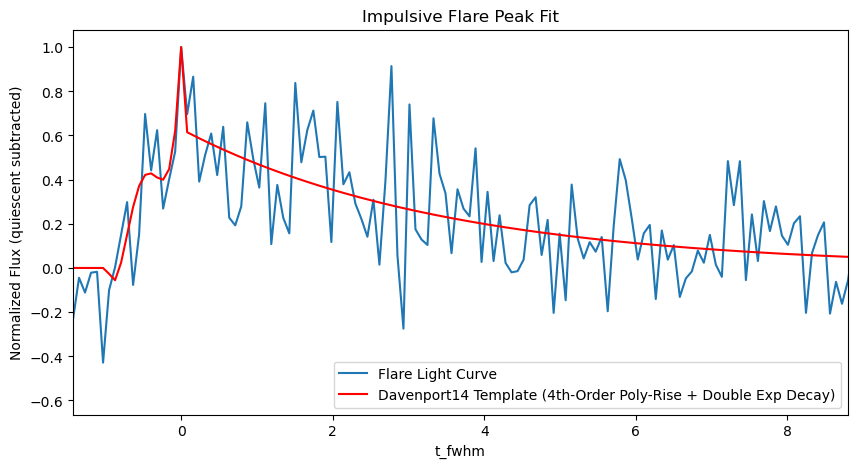

In [20]:
# Initial parameter guesses for primary flare peak
p0 = [None, None, None, None, None, None, None, None]  

popt, pcov = curve_fit(Davenport14_flare_template, t_fwhm, y_rel, maxfev=100000)
print(popt)

# Model fit for the full time range
model = Davenport14_flare_template(t_fwhm, *popt)

# Subtract model to isolate QPP substructure
qpp_substructure = y_rel - model

plt.figure(figsize=(10, 5))
plt.plot(t_fwhm, y_rel, label='Flare Light Curve')
plt.plot(t_fwhm, model, label='Davenport14 Template (4th-Order Poly-Rise + Double Exp Decay)', color='red')
# plt.plot(t_fwhm, qpp_substructure, label='QPP Substructure', color='green')
plt.xlim(t_fwhm[first_idx], t_fwhm[last_idx])
# plt.xlim(-3, 15)
plt.xlabel('t_fwhm')
plt.ylabel('Normalized Flux (quiescent subtracted)')
plt.legend()
plt.title('Impulsive Flare Peak Fit')
plt.show()

<!-- # Energy Calculation -->

Total flare fluence from fit (electrons): 2.59e+03 mJy s
Total flare energy from fit: 9.186737e+32 erg
Flare duration: 59.83 h


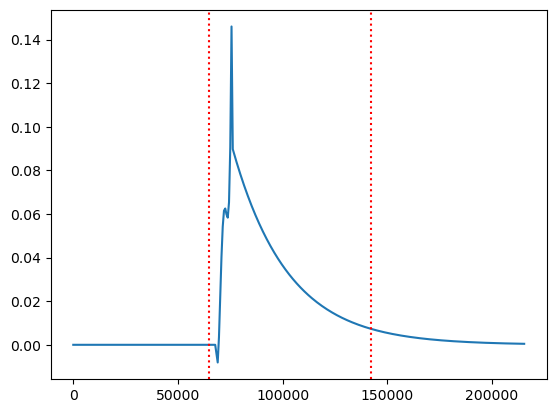

In [21]:
# model is normalized, scaling is the original flux peak
model_flux = model * scaling * 10**(-2/5*(20.44-16.4)) * u.mJy # in mJy
dt_sec = (t_fwhm - t_fwhm[0]) * fwhm * 3600*24 * u.s  # seconds since flare start
plt.plot(dt_sec, model_flux, label='Model Flux')
plt.axvline(dt_sec[first_idx].value, color='r', linestyle=':')
plt.axvline(dt_sec[last_idx].value, color='r', linestyle=':')

# Integrate model flux over time to get total fluence (electrons)
model_fluence = np.trapz(y= model_flux[first_idx:last_idx], x= dt_sec[first_idx:last_idx])
print(f"Total flare fluence from fit (electrons): {model_fluence:.2e}")

# Convert to energy (ergs)
d = (flare_star['parallax']*u.mas).to(u.cm, equivalencies= u.parallax())
# d = 1/pi -> d_err = sigma_pi / pi^2 = sigma_pi/pi * d
d_err = (flare_star['parallax_err'] * u.mas / (flare_star['parallax'] * u.mas) * d)
model_energy = (model_fluence * (2e14 * u.Hz) * (4*np.pi*d**2)).to(u.erg)
print(f"Total flare energy from fit: {model_energy:3e}")
print(f"Flare duration: {dt_sec[-1].to(u.hr):.2f}")

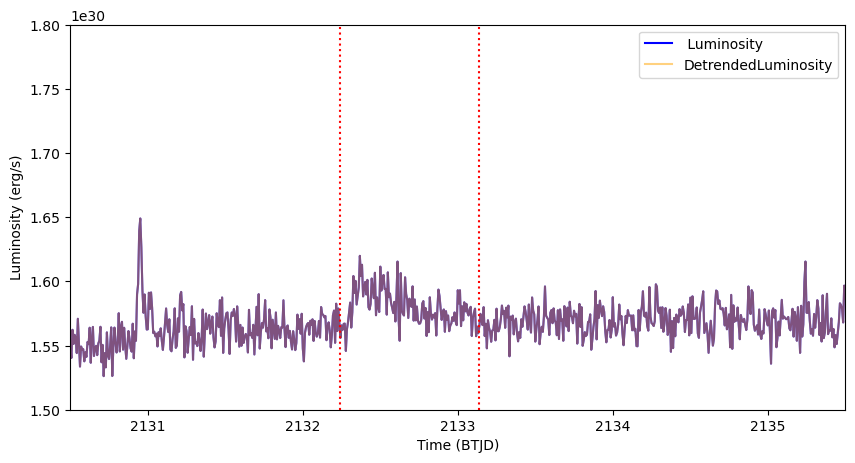

In [22]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(flc['time'].value, flc['flux'].value * 10**(-2/5*(20.44-16.4)) * 1e-26 * 2e14 * (4*np.pi*d**2), label=' Luminosity', color= 'blue')
ax.plot(flc['time'].value, flc['flux'].value * 10**(-2/5*(20.44-16.4)) * 1e-26 * 2e14 * (4*np.pi*d**2), label='DetrendedLuminosity', color= 'orange', alpha=0.5)
ax.axvline(t[first_idx], color='r', linestyle=':')
ax.axvline(t[last_idx], color='r', linestyle=':')
ax.set_xlim(2130.5, 2135.5)
# ax.set_xlim(SPT_flare['time'].value[0], SPT_flare['time'].value[-1])
ax.set_ylim(1.5e30, 1.8e30)
ax.set_xlabel('Time (BTJD)')
ax.set_ylabel('Luminosity (erg/s)')
ax.legend()

# Bolometric Energy Calculation <span style= 'color:red;'> (Test) </span>

Shibayama 2013 - https://ui.adsabs.harvard.edu/abs/2013ApJS..209....5S/abstract

In [23]:
from astropy.modeling.models import BlackBody

def BB_Lum(T, nus):
    bb_func = BlackBody(T)
    bb = bb_func(nus)

    spec_rad = np.trapz(x= nus, y= bb).to(u.erg / (u.cm**2 * u.s * u.sr))
    return spec_rad

def TESS_BB(T):
    nus = np.linspace((const.c / (1000*u.nm)), (const.c / (600*u.nm)), 1000).to(u.Hz)
    return BB_Lum(T, nus)

In [24]:
temp_time =  flare_sig['time'].copy()
temp_time =  (temp_time.value * u.day)

C_flare = flare_sig['flux'].copy() / quies

A_flare = C_flare * np.pi * (0.1665*const.R_sun.to(u.cm))**2 * TESS_BB(2935*u.K).value / TESS_BB(10000*u.K).value

L_flare = (const.sigma_sb * (10000*u.K)**4 * A_flare).to(u.erg/u.s)
max(L_flare)

<Quantity 2.32316281e+30 erg / s>

<Quantity 1.72687181e+35 erg>

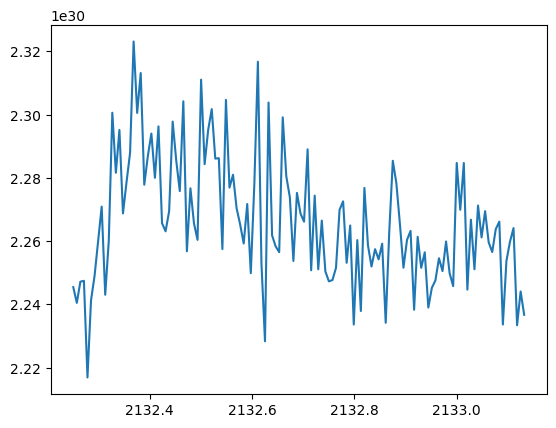

In [26]:
mask = (temp_time.value > t[first_idx]) & (temp_time.value < t[last_idx])

plt.plot(temp_time.value[mask], L_flare.value[mask])

np.trapz(x= temp_time[mask].to(u.s), y= L_flare[mask]).to(u.erg)